In [1]:
%pylab inline

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import h5py
import inspect
import os
import pandas as pd

import path_utils
path_utils.add_path_to_sys_path("../../../code/python/lib", mode="relative_to_cwd", frame=inspect.currentframe())
import embree_utils

In [3]:
metadata_camera_parameters_csv_file = os.path.join("..", "metadata_camera_parameters.csv")

#
# we use ai_037_002 as our test scene because it has an especially unusual
# projection matrix and makes use of the the following non-standard lens
# parameters in V-Ray:
# 
# horizontal_offset = 0.06
# horizontal_shift  = 0.0
# lens_shift        = -0.009
# vertical_offset   = -0.08
#

scene_name  = "ai_037_002"
camera_name = "cam_00"
frame_id    = 0

camera_dir = os.path.join(scene_name, "_detail", camera_name)
img_dir    = os.path.join(scene_name, "images")

# we need access to the Hypersim meshes in order to execute parts of this notebook
mesh_dir = "/Volumes/lacie/hypersim/evermotion_dataset/scenes/" + scene_name + "/_detail/mesh"

In [4]:
#
# read parameters from csv file
#

df_camera_parameters = pd.read_csv(metadata_camera_parameters_csv_file, index_col="scene_name")

df_ = df_camera_parameters.loc[scene_name]

width_pixels          = int(df_["settings_output_img_width"])
height_pixels         = int(df_["settings_output_img_height"])
meters_per_asset_unit = df_["settings_units_info_meters_scale"]

M_cam_from_uv = matrix([[ df_["M_cam_from_uv_00"], df_["M_cam_from_uv_01"], df_["M_cam_from_uv_02"] ],
                        [ df_["M_cam_from_uv_10"], df_["M_cam_from_uv_11"], df_["M_cam_from_uv_12"] ],
                        [ df_["M_cam_from_uv_20"], df_["M_cam_from_uv_21"], df_["M_cam_from_uv_22"] ]])

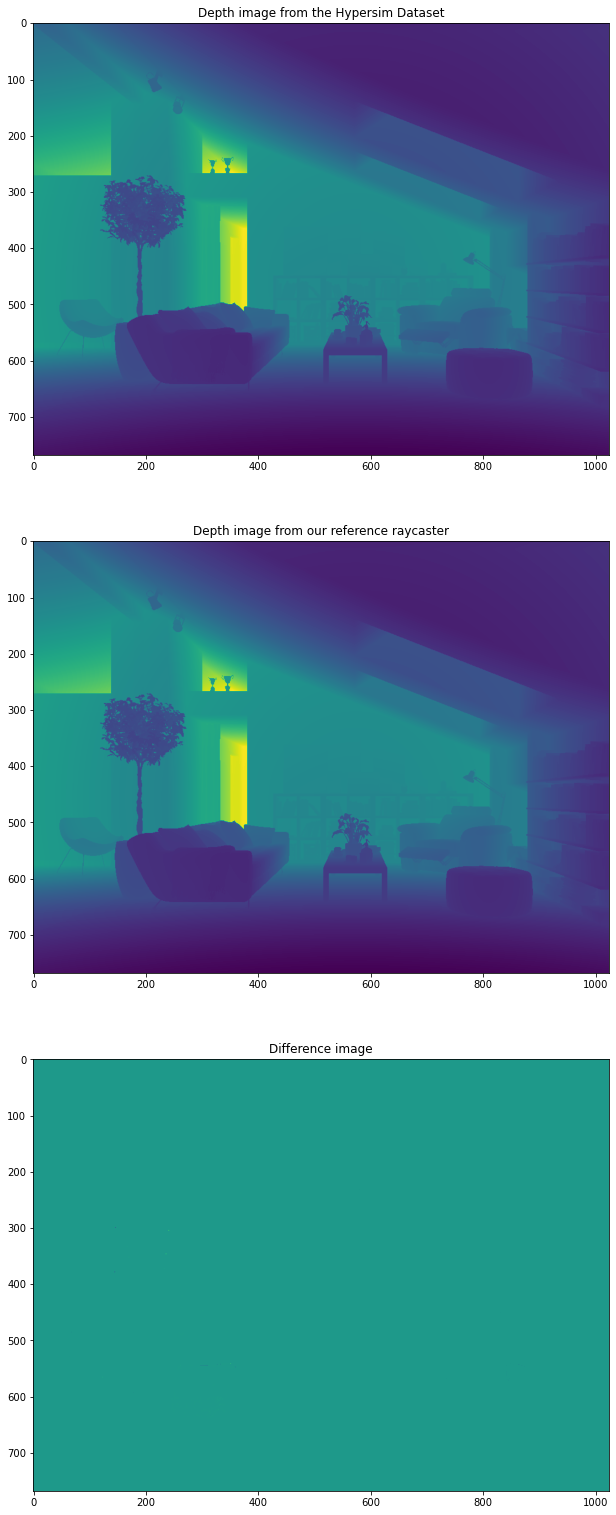

In [5]:
#
# verify that we are generating correct rays by comparing a Hypersim depth image
# to a depth image we compute ourselves using our own reference raycaster
#

# load camera trajectory data, mesh data, and a Hypersim depth image
camera_positions_hdf5_file    = os.path.join(camera_dir, "camera_keyframe_positions.hdf5")
camera_orientations_hdf5_file = os.path.join(camera_dir, "camera_keyframe_orientations.hdf5")

mesh_vertices_hdf5_file   = os.path.join(mesh_dir, "mesh_vertices.hdf5")
mesh_faces_vi_hdf5_file   = os.path.join(mesh_dir, "mesh_faces_vi.hdf5")
mesh_faces_oi_hdf5_file   = os.path.join(mesh_dir, "mesh_faces_oi.hdf5")
mesh_objects_si_hdf5_file = os.path.join(mesh_dir, "mesh_objects_si.hdf5")

depth_meters_hdf5_file = os.path.join(img_dir, "scene_" + camera_name + "_geometry_hdf5", "frame.%04d.depth_meters.hdf5" % frame_id)

with h5py.File(camera_positions_hdf5_file,    "r") as f: camera_positions    = f["dataset"][:]
with h5py.File(camera_orientations_hdf5_file, "r") as f: camera_orientations = f["dataset"][:]

with h5py.File(mesh_vertices_hdf5_file,   "r") as f: mesh_vertices   = f["dataset"][:]
with h5py.File(mesh_faces_vi_hdf5_file,   "r") as f: mesh_faces_vi   = f["dataset"][:]
with h5py.File(mesh_faces_oi_hdf5_file,   "r") as f: mesh_faces_oi   = f["dataset"][:]
with h5py.File(mesh_objects_si_hdf5_file, "r") as f: mesh_objects_si = f["dataset"][:]

with h5py.File(depth_meters_hdf5_file, "r") as f: hypersim_depth_meters = f["dataset"][:].astype(float32)

# get position and rotation matrix for Hypersim image
camera_position_world = camera_positions[frame_id]
R_world_from_cam      = camera_orientations[frame_id]

# create grid of uv-values
u_min  = -1.0
u_max  = 1.0
v_min  = -1.0
v_max  = 1.0
half_du = 0.5 * (u_max - u_min) / width_pixels
half_dv = 0.5 * (v_max - v_min) / height_pixels

u, v = meshgrid(linspace(u_min+half_du, u_max-half_du, width_pixels),
                linspace(v_min+half_dv, v_max-half_dv, height_pixels)[::-1])

uvs_2d = dstack((u,v,np.ones_like(u)))
P_uv   = matrix(uvs_2d.reshape(-1,3)).T

# compute our own rays
P_world               = R_world_from_cam * M_cam_from_uv * P_uv
ray_directions_world  = P_world.T.A
ray_positions_world   = ones_like(ray_directions_world) * camera_position_world

# get intersection distances using our own reference raycaster,
# reshape into 2D image, scale to meters
intersection_distances, intersection_normals, prim_ids = \
    embree_utils.generate_ray_intersections(mesh_vertices, mesh_faces_vi, ray_positions_world, ray_directions_world, tmp_dir="_tmp")

intersection_distances_2d = intersection_distances.reshape(height_pixels, width_pixels) * meters_per_asset_unit
difference                = hypersim_depth_meters - intersection_distances_2d

figsize(18,27)

subplot(311); imshow(hypersim_depth_meters);     title("Depth image from the Hypersim Dataset");
subplot(312); imshow(intersection_distances_2d); title("Depth image from our reference raycaster");
subplot(313); imshow(difference);                title("Difference image");
